# Elastic Modelling with Devito

This notebook showcases how to perform 2D elastic modelling Devito.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

from devitomod.elastic.el2d import Elastic2D

## 1.1 Load Velocity Model

In [2]:
f = np.load("../data/Arid_x800.npz")

vp = f['vp'] #in km/s
vs = f['vs'] #in km/s
rho = f['rho'] #in kg/m^3

x, z = f['x'],f['z'] #in m
nx, nz = len(x), len(z) #number of samples in x and z
dx, dz = x[1]-x[0], z[1]-z[0] #interval between samples

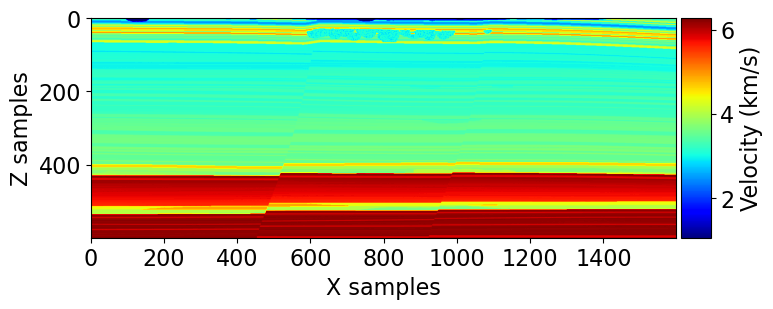

In [3]:
plt.figure(figsize=(8,8))
plot = plt.imshow(vp.T,cmap='jet',origin='upper')
plt.xlabel("X samples")
plt.ylabel("Z samples")

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot, cax=cax)
cbar.set_label('Velocity (km/s)')

plt.show()

## 1.2 Modelling Parameter

In [4]:
#Model Parameters
shape = (nx,nz)
spacing = (dx,dz)
origin = (x[0],z[0])
fs = True  #free surface
so = 6    #space order
nbl = 150  #number of boundary layers

#Defining Acquisition Geometry
nsrc = 3 #number of source
nrec = nx #number of receiver

rec_x = np.linspace(0., x[-1], num=nrec) #receiver x position
rec_z = np.ones(len(rec_x))*5 #receiver depth
src_x = np.linspace(0., x[-1], num=nsrc) #source x position
src_z = np.ones(len(src_x))*5 #source depth

# other modelling params
nbl = 150 # Number of boundary layers around the domain
so = 6 # Space order of the simulation
f0 = 20 # Source peak frequency (Hz)

t0 = 0. # Initial time
tmax = 4000 # Total simulation time (ms)
dt = 4 # Time sampling of observed data (ms)
clip = 1e-2

## 1.3 Modelling

In [5]:
# Create elastic wave equation object
ewe = Elastic2D()

In [6]:
# Inject our velocity model 
ewe.create_model(vp = vp, vs = vs, rho = rho, 
                 shape = shape, origin = origin, spacing = spacing, 
                 space_order = so, nbl=20, fs=True)

# Inject our acquisition geometry 
ewe.create_geometry(src_x = src_x, src_z = src_z,
                    rec_x = rec_x, rec_z = rec_z,
                    t0 = t0, tn = tmax, src_type = 'Ricker', f0=f0)

Operator `initdamp` ran in 0.01 s


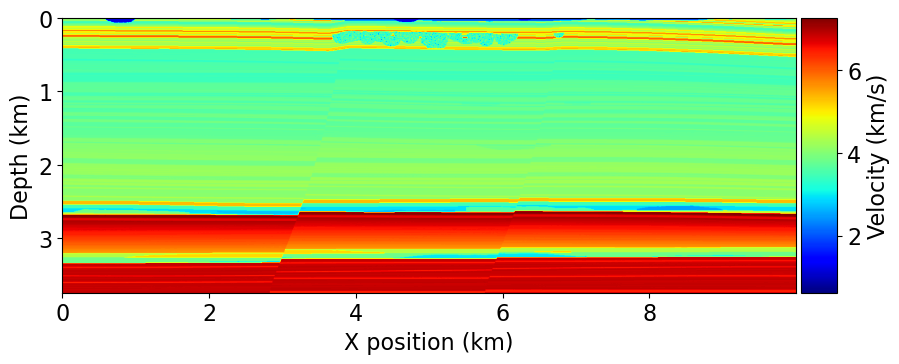

In [7]:
ewe.plot_velocity(source=False, receiver=False, figsize=(10,10))

## 1.4 Solve Single Shot

In [8]:
isrc = nsrc//2 #choose the index of shot to model
d1, _, _, _, taxis  = ewe.solve_one_shot(isrc=isrc)

Operator `ForwardElastic` ran in 29.05 s


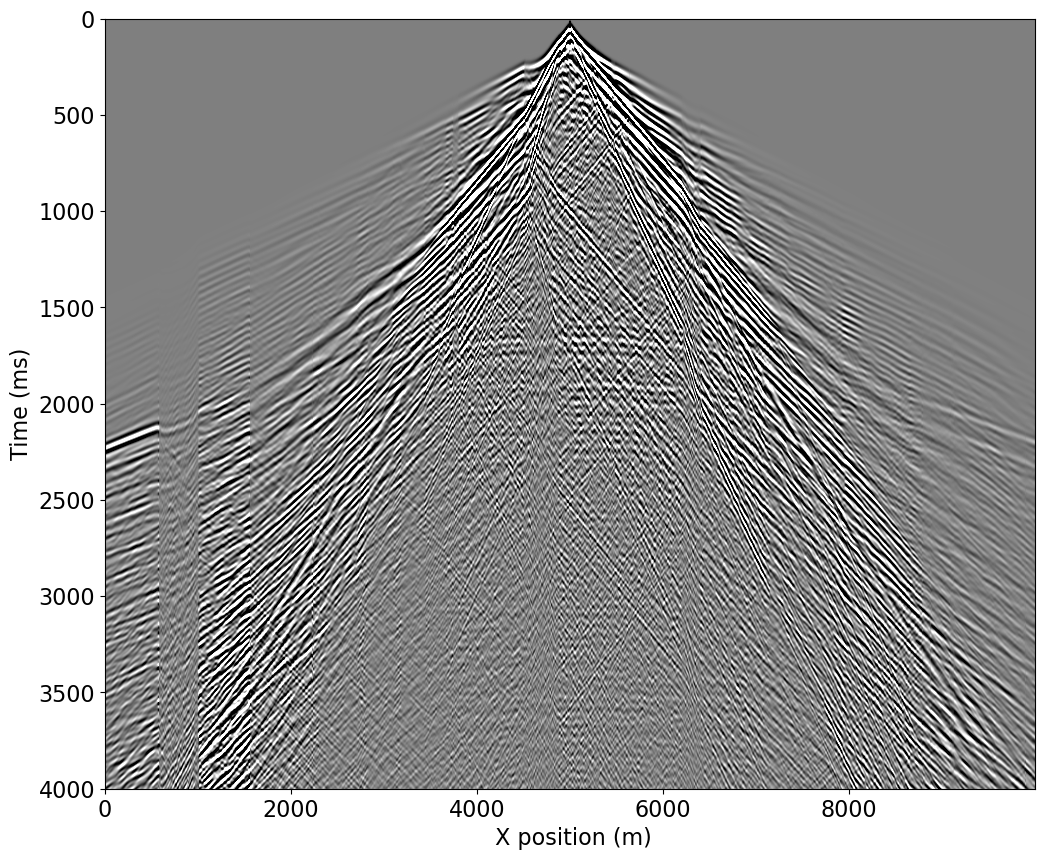

In [9]:
plt.figure(figsize=(12, 10))
plt.imshow(d1.data, cmap='gray', vmin=-clip, vmax=clip, extent=(x[0],x[-1],taxis[-1],taxis[0]))
plt.xlabel(" X position (m)")
plt.ylabel(" Time (ms) ")
plt.axis('tight');

## 1.5 Solve Multiple Shots

In [10]:
d1tot, _, taxis = ewe.solve_all_shots(savedtot=True)

100%|██████████████████████████████████████████████| 3/3 [01:34<00:00, 31.36s/it]


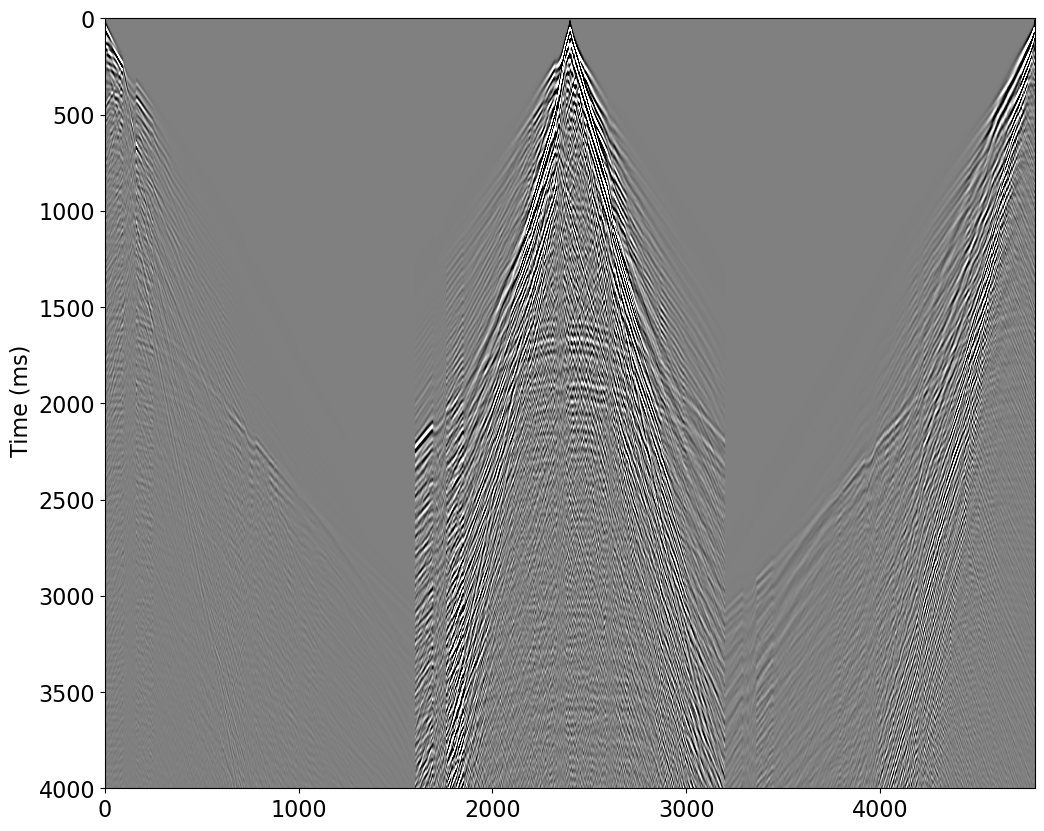

In [11]:
plt.figure(figsize=(12, 10))
plt.imshow(d1tot.reshape(nrec*nsrc, -1).T, cmap='gray', vmin=-clip, vmax=clip, extent=(0,nrec*nsrc,taxis[-1],taxis[0]))
plt.ylabel(" Time (ms)")
plt.axis('tight');